In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last" # all | last | last_expr | none 

In [3]:
# ============= Import required packaages ==============
import time
import os
import tensorflow as tf

# Import all custom variables and modules
from custom_classes_defs.setup import *
from custom_classes_defs.preprocessing import *
from custom_classes_defs.Unet_like import *   
from custom_classes_defs.fnet import *

RND_STATE = 247
BATCH_SIZE = 500
keras.utils.set_random_seed(RND_STATE)

INTERACTIVE_SESSION = True

from tensorflow.data import Dataset as tf_data
# -------------------------------------------------------

2024-04-19 22:44:20.298890: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-19 22:44:20.740223: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-19 22:44:20.740589: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-19 22:44:20.798421: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-19 22:44:20.942391: I tensorflow/core/platform/cpu_feature_guar

### Data preparation and model configurations

---------------

In [4]:
class SeismicData():
    """
    Loading, scaling and preprocessing of the seismic data:
    Returns: tf-datasets
    """
    def __init__(self,
            input_img_paths,
            target_img_paths,
            img_size=(96, 96),
            batch_size=BATCH_SIZE
        ):
        #super().__init__()
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths
        self.img_size = img_size
        self.batch_size = batch_size
    
    def load_img_masks(self,path):
        data = []
        for file_name in os.listdir(path):
            file_path = os.path.join(path, file_name)
            if file_name.endswith('.npy'):
                numpy_array = np.load(file_path)
                #print(f"Array loaded from '{file_name}' has shape: {numpy_array.shape}")
                data.append(numpy_array)
        print(f"\nThe concatenated array has shape: {np.shape(data)}")
        return np.array(data)

    def get_dataset(self):
        """Returns a TF Dataset."""
        x_train =self.load_img_masks(self.input_img_paths)
        y_train = self.load_img_masks(self.target_img_paths)
        dataset = tf_data.from_tensor_slices((x_train, y_train))
        #dataset = dataset.prefetch(num_parallel_calls=tf_data.AUTOTUNE)
        return dataset.batch(self.batch_size)
    

In [5]:
# Input data path

path = '../data_input/processed_patches'

seis_train_path = '{}/seismic/train/'.format(path)
fault_train_path = '{}/fault/train/'.format(path)

seis_val_path = '{}/seismic/val/'.format(path)
fault_val_path ='{}/fault/val/'.format(path)

seis_test_path = '{}/seismic/test/'.format(path)
fault_test_path = '{}/fault/test/'.format(path)

train_data = SeismicData(seis_train_path,fault_train_path)
validation_data = SeismicData(seis_val_path,fault_val_path)
test_data = SeismicData(seis_test_path,fault_test_path)

train_dataset = train_data.get_dataset()
val_dataset = validation_data.get_dataset()


The concatenated array has shape: (181029, 96, 96)



The concatenated array has shape: (181029, 96, 96)


2024-04-19 22:57:35.972839: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 37785 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:3b:00.0, compute capability: 8.0


2024-04-19 22:57:35.978335: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38374 MB memory:  -> device: 1, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:af:00.0, compute capability: 8.0



The concatenated array has shape: (64317, 96, 96)



The concatenated array has shape: (64317, 96, 96)


In [6]:
test_seismic = test_data.load_img_masks(seis_test_path)
test_label = test_data.load_img_masks(fault_test_path)



The concatenated array has shape: (66077, 96, 96)



The concatenated array has shape: (66077, 96, 96)


In [7]:

# Model configurations
conf = model_config(
    epochs=50,
    batch_size=BATCH_SIZE,
    shuffle=True,
    scaling=1,
    img_shape=(96,96), 
    target_size=(96,96), 
    verbose=1,
    save_path='../data_input/processed_patches/output/',
    augmentation=True
)


es_callback = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

conf.set( validation_data=val_dataset,  callbacks=[es_callback] )
conf.set('compile')
conf.info()

        compile_args:
                     optimizer: adam
                          loss: binary_crossentropy
       training_args:
                        epochs: 50
                    batch_size: 500
                       shuffle: True
                       verbose: 1
               validation_data: <class 'tensorflow.python.data.ops.batch_op._BatchDataset'>
                     callbacks: <class 'tensorflow.python.trackable.data_structures.ListWrapper'>
          model_arch:
                     img_shape: (96, 96)
                   target_size: (96, 96)
                  channels_dim: (1, 1)
                       scaling: 1
                  augmentation: True
new_training_session: False
           save_path: ../data_input/processed_patches/output/
           threshold: 0.5
           pos_label: 1


### Build  model 

In [8]:
print("\n\n{}\n\t{}\n{}".format('='*55,f'Build model', '-'*55))
m_obj = UNET2D(panel_sizes=[32,64,128,256], model_arch=conf.model_arch)
#m_obj = FNET2D(panel_sizes=[32,64,128,256], model_arch=conf.model_arch)

model = m_obj.build_model()
model.summary()
#keras.utils.plot_model(model, 'm_obj.png',show_shapes=True)
print(f"Total trainable wieghts: {model.count_params():,}")




	Build model
-------------------------------------------------------


Model: "U-NET"


__________________________________________________________________________________________________


 Layer (type)                Output Shape                 Param #   Connected to                  


 input_1 (InputLayer)        [(None, 96, 96, 1)]          0         []                            


 sequential (Sequential)     (None, 96, 96, 1)            0         ['input_1[0][0]']             


 conv2d (Conv2D)             (None, 48, 48, 32)           320       ['sequential[0][0]']          


 batch_normalization (Batch  (None, 48, 48, 32)           128       ['conv2d[0][0]']              


 Normalization)                                                                                   


 activation (Activation)     (None, 48, 48, 32)           0         ['batch_normalization[0][0]'] 


 activation_1 (Activation)   (None, 48, 48, 32)           0         ['activation[0][0]']          


 separable_conv2d (Separabl  (None, 48, 48, 64)           2400      ['activation_1[0][0]']        


 eConv2D)                                                                                         


 batch_normalization_1 (Bat  (None, 48, 48, 64)           256       ['separable_conv2d[0][0]']    


 chNormalization)                                                                                 


 activation_2 (Activation)   (None, 48, 48, 64)           0         ['batch_normalization_1[0][0]'


                                                                    ]                             


 separable_conv2d_1 (Separa  (None, 48, 48, 64)           4736      ['activation_2[0][0]']        


 bleConv2D)                                                                                       


 batch_normalization_2 (Bat  (None, 48, 48, 64)           256       ['separable_conv2d_1[0][0]']  


 chNormalization)                                                                                 


 max_pooling2d (MaxPooling2  (None, 24, 24, 64)           0         ['batch_normalization_2[0][0]'


 D)                                                                 ]                             


 conv2d_1 (Conv2D)           (None, 24, 24, 64)           2112      ['activation[0][0]']          


 add (Add)                   (None, 24, 24, 64)           0         ['max_pooling2d[0][0]',       


                                                                     'conv2d_1[0][0]']            


 activation_3 (Activation)   (None, 24, 24, 64)           0         ['add[0][0]']                 


 separable_conv2d_2 (Separa  (None, 24, 24, 128)          8896      ['activation_3[0][0]']        


 bleConv2D)                                                                                       


 batch_normalization_3 (Bat  (None, 24, 24, 128)          512       ['separable_conv2d_2[0][0]']  


 chNormalization)                                                                                 


 activation_4 (Activation)   (None, 24, 24, 128)          0         ['batch_normalization_3[0][0]'


                                                                    ]                             


 separable_conv2d_3 (Separa  (None, 24, 24, 128)          17664     ['activation_4[0][0]']        


 bleConv2D)                                                                                       


 batch_normalization_4 (Bat  (None, 24, 24, 128)          512       ['separable_conv2d_3[0][0]']  


 chNormalization)                                                                                 


 max_pooling2d_1 (MaxPoolin  (None, 12, 12, 128)          0         ['batch_normalization_4[0][0]'


 g2D)                                                               ]                             


 conv2d_2 (Conv2D)           (None, 12, 12, 128)          8320      ['add[0][0]']                 


 add_1 (Add)                 (None, 12, 12, 128)          0         ['max_pooling2d_1[0][0]',     


                                                                     'conv2d_2[0][0]']            


 activation_5 (Activation)   (None, 12, 12, 128)          0         ['add_1[0][0]']               


 separable_conv2d_4 (Separa  (None, 12, 12, 256)          34176     ['activation_5[0][0]']        


 bleConv2D)                                                                                       


 batch_normalization_5 (Bat  (None, 12, 12, 256)          1024      ['separable_conv2d_4[0][0]']  


 chNormalization)                                                                                 


 activation_6 (Activation)   (None, 12, 12, 256)          0         ['batch_normalization_5[0][0]'


                                                                    ]                             


 separable_conv2d_5 (Separa  (None, 12, 12, 256)          68096     ['activation_6[0][0]']        


 bleConv2D)                                                                                       


 batch_normalization_6 (Bat  (None, 12, 12, 256)          1024      ['separable_conv2d_5[0][0]']  


 chNormalization)                                                                                 


 max_pooling2d_2 (MaxPoolin  (None, 6, 6, 256)            0         ['batch_normalization_6[0][0]'


 g2D)                                                               ]                             


 conv2d_3 (Conv2D)           (None, 6, 6, 256)            33024     ['add_1[0][0]']               


 add_2 (Add)                 (None, 6, 6, 256)            0         ['max_pooling2d_2[0][0]',     


                                                                     'conv2d_3[0][0]']            


 activation_7 (Activation)   (None, 6, 6, 256)            0         ['add_2[0][0]']               


 conv2d_transpose (Conv2DTr  (None, 6, 6, 256)            590080    ['activation_7[0][0]']        


 anspose)                                                                                         


 batch_normalization_7 (Bat  (None, 6, 6, 256)            1024      ['conv2d_transpose[0][0]']    


 chNormalization)                                                                                 


 activation_8 (Activation)   (None, 6, 6, 256)            0         ['batch_normalization_7[0][0]'


                                                                    ]                             


 conv2d_transpose_1 (Conv2D  (None, 6, 6, 256)            590080    ['activation_8[0][0]']        


 Transpose)                                                                                       


 batch_normalization_8 (Bat  (None, 6, 6, 256)            1024      ['conv2d_transpose_1[0][0]']  


 chNormalization)                                                                                 


 up_sampling2d_1 (UpSamplin  (None, 12, 12, 256)          0         ['add_2[0][0]']               


 g2D)                                                                                             


 up_sampling2d (UpSampling2  (None, 12, 12, 256)          0         ['batch_normalization_8[0][0]'


 D)                                                                 ]                             


 conv2d_4 (Conv2D)           (None, 12, 12, 256)          65792     ['up_sampling2d_1[0][0]']     


 add_3 (Add)                 (None, 12, 12, 256)          0         ['up_sampling2d[0][0]',       


                                                                     'conv2d_4[0][0]']            


 activation_9 (Activation)   (None, 12, 12, 256)          0         ['add_3[0][0]']               


 conv2d_transpose_2 (Conv2D  (None, 12, 12, 128)          295040    ['activation_9[0][0]']        


 Transpose)                                                                                       


 batch_normalization_9 (Bat  (None, 12, 12, 128)          512       ['conv2d_transpose_2[0][0]']  


 chNormalization)                                                                                 


 activation_10 (Activation)  (None, 12, 12, 128)          0         ['batch_normalization_9[0][0]'


                                                                    ]                             


 conv2d_transpose_3 (Conv2D  (None, 12, 12, 128)          147584    ['activation_10[0][0]']       


 Transpose)                                                                                       


 batch_normalization_10 (Ba  (None, 12, 12, 128)          512       ['conv2d_transpose_3[0][0]']  


 tchNormalization)                                                                                


 up_sampling2d_3 (UpSamplin  (None, 24, 24, 256)          0         ['add_3[0][0]']               


 g2D)                                                                                             


 up_sampling2d_2 (UpSamplin  (None, 24, 24, 128)          0         ['batch_normalization_10[0][0]


 g2D)                                                               ']                            


 conv2d_5 (Conv2D)           (None, 24, 24, 128)          32896     ['up_sampling2d_3[0][0]']     


 add_4 (Add)                 (None, 24, 24, 128)          0         ['up_sampling2d_2[0][0]',     


                                                                     'conv2d_5[0][0]']            


 activation_11 (Activation)  (None, 24, 24, 128)          0         ['add_4[0][0]']               


 conv2d_transpose_4 (Conv2D  (None, 24, 24, 64)           73792     ['activation_11[0][0]']       


 Transpose)                                                                                       


 batch_normalization_11 (Ba  (None, 24, 24, 64)           256       ['conv2d_transpose_4[0][0]']  


 tchNormalization)                                                                                


 activation_12 (Activation)  (None, 24, 24, 64)           0         ['batch_normalization_11[0][0]


                                                                    ']                            


 conv2d_transpose_5 (Conv2D  (None, 24, 24, 64)           36928     ['activation_12[0][0]']       


 Transpose)                                                                                       


 batch_normalization_12 (Ba  (None, 24, 24, 64)           256       ['conv2d_transpose_5[0][0]']  


 tchNormalization)                                                                                


 up_sampling2d_5 (UpSamplin  (None, 48, 48, 128)          0         ['add_4[0][0]']               


 g2D)                                                                                             


 up_sampling2d_4 (UpSamplin  (None, 48, 48, 64)           0         ['batch_normalization_12[0][0]


 g2D)                                                               ']                            


 conv2d_6 (Conv2D)           (None, 48, 48, 64)           8256      ['up_sampling2d_5[0][0]']     


 add_5 (Add)                 (None, 48, 48, 64)           0         ['up_sampling2d_4[0][0]',     


                                                                     'conv2d_6[0][0]']            


 activation_13 (Activation)  (None, 48, 48, 64)           0         ['add_5[0][0]']               


 conv2d_transpose_6 (Conv2D  (None, 48, 48, 32)           18464     ['activation_13[0][0]']       


 Transpose)                                                                                       


 batch_normalization_13 (Ba  (None, 48, 48, 32)           128       ['conv2d_transpose_6[0][0]']  


 tchNormalization)                                                                                


 activation_14 (Activation)  (None, 48, 48, 32)           0         ['batch_normalization_13[0][0]


                                                                    ']                            


 conv2d_transpose_7 (Conv2D  (None, 48, 48, 32)           9248      ['activation_14[0][0]']       


 Transpose)                                                                                       


 batch_normalization_14 (Ba  (None, 48, 48, 32)           128       ['conv2d_transpose_7[0][0]']  


 tchNormalization)                                                                                


 up_sampling2d_7 (UpSamplin  (None, 96, 96, 64)           0         ['add_5[0][0]']               


 g2D)                                                                                             


 up_sampling2d_6 (UpSamplin  (None, 96, 96, 32)           0         ['batch_normalization_14[0][0]


 g2D)                                                               ']                            


 conv2d_7 (Conv2D)           (None, 96, 96, 32)           2080      ['up_sampling2d_7[0][0]']     


 add_6 (Add)                 (None, 96, 96, 32)           0         ['up_sampling2d_6[0][0]',     


                                                                     'conv2d_7[0][0]']            


 conv2d_8 (Conv2D)           (None, 96, 96, 1)            289       ['add_6[0][0]']               


Total params: 2057825 (7.85 MB)


Trainable params: 2054049 (7.84 MB)


Non-trainable params: 3776 (14.75 KB)


__________________________________________________________________________________________________


Total trainable wieghts: 2,057,825


### Train and evaluate  model



	Train unet model
-------------------------------------------------------


model weights  (unet.weights.h5) and train history loaded!


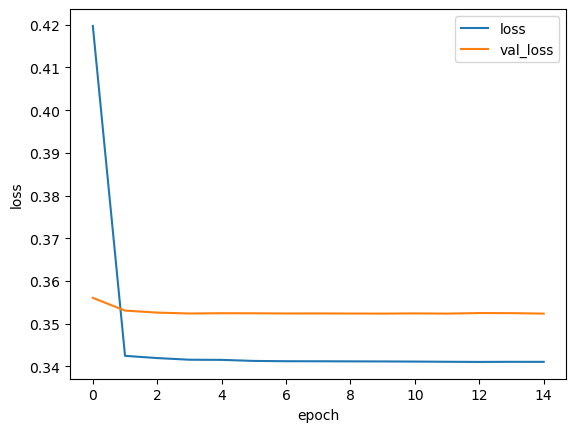

In [9]:

print("\n\n{}\n\t{}\n{}".format('='*55,f'Train {m_obj.Name} model', '-'*55))

conf.execute_training(
    model, 
    data=train_dataset, 
    saveas=m_obj.Name, 
    plot_history=INTERACTIVE_SESSION
)


In [10]:
x_test = np.expand_dims(test_seismic,axis=-1)
y_test = test_label

In [11]:
print("\n\n{}\n\t{}\n{}".format('='*55,f'Evaluate {m_obj.Name} model', '-'*55))
# fault label probabilities
decoded_imgs = model.predict(x_test)
scores = m_obj.evaluate_sklearn(y_test, decoded_imgs,report=True)
print(scores)



	Evaluate unet model
-------------------------------------------------------


2024-04-19 23:06:53.359065: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907


   1/2065 [..............................] - ETA: 3:51:46

   7/2065 [..............................] - ETA: 17s    

  14/2065 [..............................] - ETA: 16s

  22/2065 [..............................] - ETA: 15s

  30/2065 [..............................] - ETA: 14s

  38/2065 [..............................] - ETA: 14s

  46/2065 [..............................] - ETA: 14s

  54/2065 [..............................] - ETA: 14s

  62/2065 [..............................] - ETA: 13s

  69/2065 [>.............................] - ETA: 13s

  78/2065 [>.............................] - ETA: 13s

  86/2065 [>.............................] - ETA: 13s

  93/2065 [>.............................] - ETA: 13s

 101/2065 [>.............................] - ETA: 13s

 108/2065 [>.............................] - ETA: 13s

 116/2065 [>.............................] - ETA: 13s

 124/2065 [>.............................] - ETA: 13s

 132/2065 [>.............................] - ETA: 13s

 140/2065 [=>............................] - ETA: 13s

 148/2065 [=>............................] - ETA: 13s

 155/2065 [=>............................] - ETA: 13s

 163/2065 [=>............................] - ETA: 13s

 171/2065 [=>............................] - ETA: 12s

 179/2065 [=>............................] - ETA: 12s

 187/2065 [=>............................] - ETA: 12s

 196/2065 [=>............................] - ETA: 12s

 203/2065 [=>............................] - ETA: 12s

 212/2065 [==>...........................] - ETA: 12s

 220/2065 [==>...........................] - ETA: 12s

 228/2065 [==>...........................] - ETA: 12s

 236/2065 [==>...........................] - ETA: 12s

 244/2065 [==>...........................] - ETA: 12s

 253/2065 [==>...........................] - ETA: 12s

 261/2065 [==>...........................] - ETA: 12s

 269/2065 [==>...........................] - ETA: 12s

 276/2065 [===>..........................] - ETA: 12s

 283/2065 [===>..........................] - ETA: 12s

 291/2065 [===>..........................] - ETA: 11s

 298/2065 [===>..........................] - ETA: 12s

 306/2065 [===>..........................] - ETA: 11s

 313/2065 [===>..........................] - ETA: 11s

 320/2065 [===>..........................] - ETA: 11s

 328/2065 [===>..........................] - ETA: 11s

 337/2065 [===>..........................] - ETA: 11s

 345/2065 [====>.........................] - ETA: 11s

 352/2065 [====>.........................] - ETA: 11s

 360/2065 [====>.........................] - ETA: 11s

 367/2065 [====>.........................] - ETA: 11s

 375/2065 [====>.........................] - ETA: 11s

 380/2065 [====>.........................] - ETA: 11s

 388/2065 [====>.........................] - ETA: 11s

 397/2065 [====>.........................] - ETA: 11s

 405/2065 [====>.........................] - ETA: 11s

 413/2065 [=====>........................] - ETA: 11s

 421/2065 [=====>........................] - ETA: 11s

 429/2065 [=====>........................] - ETA: 11s

 438/2065 [=====>........................] - ETA: 11s

 447/2065 [=====>........................] - ETA: 11s

 455/2065 [=====>........................] - ETA: 10s

 463/2065 [=====>........................] - ETA: 10s

 471/2065 [=====>........................] - ETA: 10s

 478/2065 [=====>........................] - ETA: 10s

 485/2065 [======>.......................] - ETA: 10s

 492/2065 [======>.......................] - ETA: 10s

 500/2065 [======>.......................] - ETA: 10s

 507/2065 [======>.......................] - ETA: 10s

 514/2065 [======>.......................] - ETA: 10s

 522/2065 [======>.......................] - ETA: 10s

 529/2065 [======>.......................] - ETA: 10s

 538/2065 [======>.......................] - ETA: 10s

 546/2065 [======>.......................] - ETA: 10s

 554/2065 [=======>......................] - ETA: 10s

 561/2065 [=======>......................] - ETA: 10s

 570/2065 [=======>......................] - ETA: 10s

 579/2065 [=======>......................] - ETA: 10s

 588/2065 [=======>......................] - ETA: 10s

 597/2065 [=======>......................] - ETA: 9s 

 605/2065 [=======>......................] - ETA: 9s

 614/2065 [=======>......................] - ETA: 9s

 622/2065 [========>.....................] - ETA: 9s

 630/2065 [========>.....................] - ETA: 9s

 638/2065 [========>.....................] - ETA: 9s

 646/2065 [========>.....................] - ETA: 9s

 655/2065 [========>.....................] - ETA: 9s

 662/2065 [========>.....................] - ETA: 9s

 670/2065 [========>.....................] - ETA: 9s

 678/2065 [========>.....................] - ETA: 9s

 685/2065 [========>.....................] - ETA: 9s

 693/2065 [=========>....................] - ETA: 9s

 701/2065 [=========>....................] - ETA: 9s

 708/2065 [=========>....................] - ETA: 9s

 716/2065 [=========>....................] - ETA: 9s

 725/2065 [=========>....................] - ETA: 9s

 733/2065 [=========>....................] - ETA: 8s

 743/2065 [=========>....................] - ETA: 8s

 752/2065 [=========>....................] - ETA: 8s

 760/2065 [==========>...................] - ETA: 8s

 768/2065 [==========>...................] - ETA: 8s

 776/2065 [==========>...................] - ETA: 8s

 784/2065 [==========>...................] - ETA: 8s

 792/2065 [==========>...................] - ETA: 8s

 800/2065 [==========>...................] - ETA: 8s

 810/2065 [==========>...................] - ETA: 8s

 818/2065 [==========>...................] - ETA: 8s

 826/2065 [===========>..................] - ETA: 8s

 835/2065 [===========>..................] - ETA: 8s

 843/2065 [===========>..................] - ETA: 8s

 849/2065 [===========>..................] - ETA: 8s

 856/2065 [===========>..................] - ETA: 8s

 863/2065 [===========>..................] - ETA: 8s

 871/2065 [===========>..................] - ETA: 7s

 879/2065 [===========>..................] - ETA: 7s

 883/2065 [===========>..................] - ETA: 7s

 891/2065 [===========>..................] - ETA: 7s

 896/2065 [============>.................] - ETA: 7s

 904/2065 [============>.................] - ETA: 7s

 912/2065 [============>.................] - ETA: 7s

 919/2065 [============>.................] - ETA: 7s

 927/2065 [============>.................] - ETA: 7s

 935/2065 [============>.................] - ETA: 7s

 941/2065 [============>.................] - ETA: 7s

 948/2065 [============>.................] - ETA: 7s

 954/2065 [============>.................] - ETA: 7s

 960/2065 [============>.................] - ETA: 7s

 968/2065 [=============>................] - ETA: 7s

 975/2065 [=============>................] - ETA: 7s

 984/2065 [=============>................] - ETA: 7s

 993/2065 [=============>................] - ETA: 7s

1001/2065 [=============>................] - ETA: 7s

1009/2065 [=============>................] - ETA: 7s

1018/2065 [=============>................] - ETA: 7s

1026/2065 [=============>................] - ETA: 7s

1034/2065 [==============>...............] - ETA: 7s

1038/2065 [==============>...............] - ETA: 7s

1046/2065 [==============>...............] - ETA: 6s

1054/2065 [==============>...............] - ETA: 6s

1059/2065 [==============>...............] - ETA: 6s

1067/2065 [==============>...............] - ETA: 6s

1075/2065 [==============>...............] - ETA: 6s

1082/2065 [==============>...............] - ETA: 6s

1090/2065 [==============>...............] - ETA: 6s

1098/2065 [==============>...............] - ETA: 6s

1107/2065 [===============>..............] - ETA: 6s

1115/2065 [===============>..............] - ETA: 6s

1124/2065 [===============>..............] - ETA: 6s

1131/2065 [===============>..............] - ETA: 6s

1139/2065 [===============>..............] - ETA: 6s

1147/2065 [===============>..............] - ETA: 6s

1155/2065 [===============>..............] - ETA: 6s

1164/2065 [===============>..............] - ETA: 6s

1173/2065 [================>.............] - ETA: 6s

1182/2065 [================>.............] - ETA: 6s

1191/2065 [================>.............] - ETA: 5s

1200/2065 [================>.............] - ETA: 5s

1209/2065 [================>.............] - ETA: 5s

1218/2065 [================>.............] - ETA: 5s

1226/2065 [================>.............] - ETA: 5s

1233/2065 [================>.............] - ETA: 5s

1241/2065 [=================>............] - ETA: 5s

1249/2065 [=================>............] - ETA: 5s

1257/2065 [=================>............] - ETA: 5s

1266/2065 [=================>............] - ETA: 5s

1274/2065 [=================>............] - ETA: 5s

1282/2065 [=================>............] - ETA: 5s

1291/2065 [=================>............] - ETA: 5s

1299/2065 [=================>............] - ETA: 5s

1307/2065 [=================>............] - ETA: 5s

1315/2065 [==================>...........] - ETA: 5s

1324/2065 [==================>...........] - ETA: 5s

1333/2065 [==================>...........] - ETA: 4s

1342/2065 [==================>...........] - ETA: 4s

1351/2065 [==================>...........] - ETA: 4s

1359/2065 [==================>...........] - ETA: 4s

1368/2065 [==================>...........] - ETA: 4s

1376/2065 [==================>...........] - ETA: 4s

1383/2065 [===================>..........] - ETA: 4s

1391/2065 [===================>..........] - ETA: 4s

1399/2065 [===================>..........] - ETA: 4s

1407/2065 [===================>..........] - ETA: 4s

1416/2065 [===================>..........] - ETA: 4s

1424/2065 [===================>..........] - ETA: 4s

1432/2065 [===================>..........] - ETA: 4s

1435/2065 [===================>..........] - ETA: 4s

1444/2065 [===================>..........] - ETA: 4s

1450/2065 [====================>.........] - ETA: 4s

1459/2065 [====================>.........] - ETA: 4s

1467/2065 [====================>.........] - ETA: 4s

1475/2065 [====================>.........] - ETA: 3s

1483/2065 [====================>.........] - ETA: 3s

1491/2065 [====================>.........] - ETA: 3s

1499/2065 [====================>.........] - ETA: 3s

1507/2065 [====================>.........] - ETA: 3s

1516/2065 [=====================>........] - ETA: 3s

1525/2065 [=====================>........] - ETA: 3s

1533/2065 [=====================>........] - ETA: 3s

1541/2065 [=====================>........] - ETA: 3s

1549/2065 [=====================>........] - ETA: 3s

1558/2065 [=====================>........] - ETA: 3s

1567/2065 [=====================>........] - ETA: 3s

1576/2065 [=====================>........] - ETA: 3s

1585/2065 [======================>.......] - ETA: 3s

1594/2065 [======================>.......] - ETA: 3s

1602/2065 [======================>.......] - ETA: 3s

1610/2065 [======================>.......] - ETA: 3s

1619/2065 [======================>.......] - ETA: 2s

1627/2065 [======================>.......] - ETA: 2s

1635/2065 [======================>.......] - ETA: 2s

1644/2065 [======================>.......] - ETA: 2s

1652/2065 [=======================>......] - ETA: 2s

1658/2065 [=======================>......] - ETA: 2s

1666/2065 [=======================>......] - ETA: 2s

1674/2065 [=======================>......] - ETA: 2s

1684/2065 [=======================>......] - ETA: 2s

1693/2065 [=======================>......] - ETA: 2s

1702/2065 [=======================>......] - ETA: 2s

1707/2065 [=======================>......] - ETA: 2s

1716/2065 [=======================>......] - ETA: 2s

1725/2065 [========================>.....] - ETA: 2s

1733/2065 [========================>.....] - ETA: 2s

1741/2065 [========================>.....] - ETA: 2s

1750/2065 [========================>.....] - ETA: 2s

1758/2065 [========================>.....] - ETA: 2s

1762/2065 [========================>.....] - ETA: 2s

1771/2065 [========================>.....] - ETA: 1s

1780/2065 [========================>.....] - ETA: 1s

1785/2065 [========================>.....] - ETA: 1s

1792/2065 [=========================>....] - ETA: 1s

1800/2065 [=========================>....] - ETA: 1s

1808/2065 [=========================>....] - ETA: 1s

1817/2065 [=========================>....] - ETA: 1s

1825/2065 [=========================>....] - ETA: 1s

1832/2065 [=========================>....] - ETA: 1s

1840/2065 [=========================>....] - ETA: 1s

1847/2065 [=========================>....] - ETA: 1s

1855/2065 [=========================>....] - ETA: 1s

1863/2065 [==========================>...] - ETA: 1s

1869/2065 [==========================>...] - ETA: 1s

1877/2065 [==========================>...] - ETA: 1s

1885/2065 [==========================>...] - ETA: 1s

1893/2065 [==========================>...] - ETA: 1s

1901/2065 [==========================>...] - ETA: 1s

1910/2065 [==========================>...] - ETA: 1s

1917/2065 [==========================>...] - ETA: 0s

1926/2065 [==========================>...] - ETA: 0s

1935/2065 [===========================>..] - ETA: 0s

1943/2065 [===========================>..] - ETA: 0s

1952/2065 [===========================>..] - ETA: 0s

1959/2065 [===========================>..] - ETA: 0s

1967/2065 [===========================>..] - ETA: 0s

1976/2065 [===========================>..] - ETA: 0s

1983/2065 [===========================>..] - ETA: 0s

1992/2065 [===========================>..] - ETA: 0s

2001/2065 [============================>.] - ETA: 0s

2010/2065 [============================>.] - ETA: 0s

2018/2065 [============================>.] - ETA: 0s

2027/2065 [============================>.] - ETA: 0s

2035/2065 [============================>.] - ETA: 0s

2043/2065 [============================>.] - ETA: 0s

2051/2065 [============================>.] - ETA: 0s

2058/2065 [============================>.] - ETA: 0s

2065/2065 [==============================] - ETA: 0s

2065/2065 [==============================] - 21s 7ms/step


evaluation elapsed time:___42.55___minutes


{'Avg-precision': 0.11, 'f1-score(ODS)': 0.18, 'f1-score(OIS)': 0.18}


In [12]:
#evaluation = model.evaluate(x_test,y_test)
#print(evaluation)

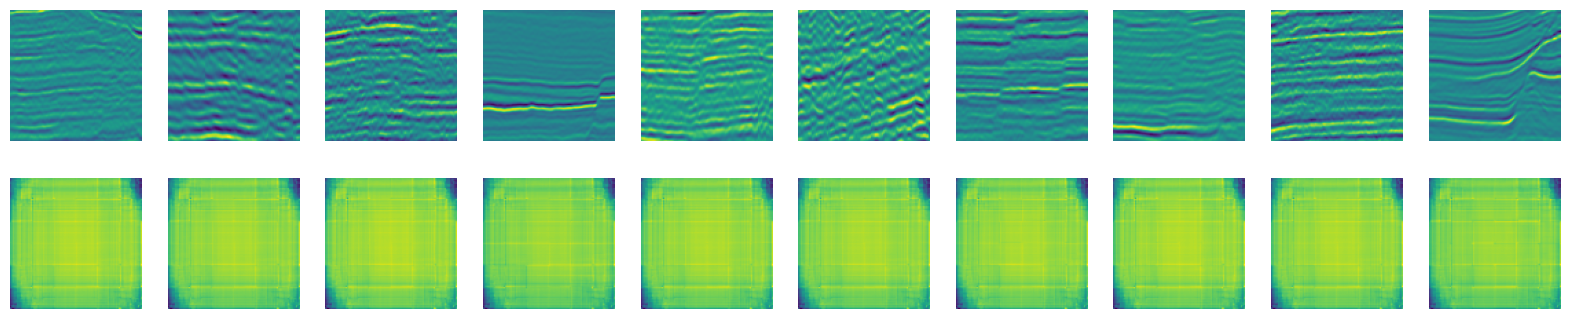

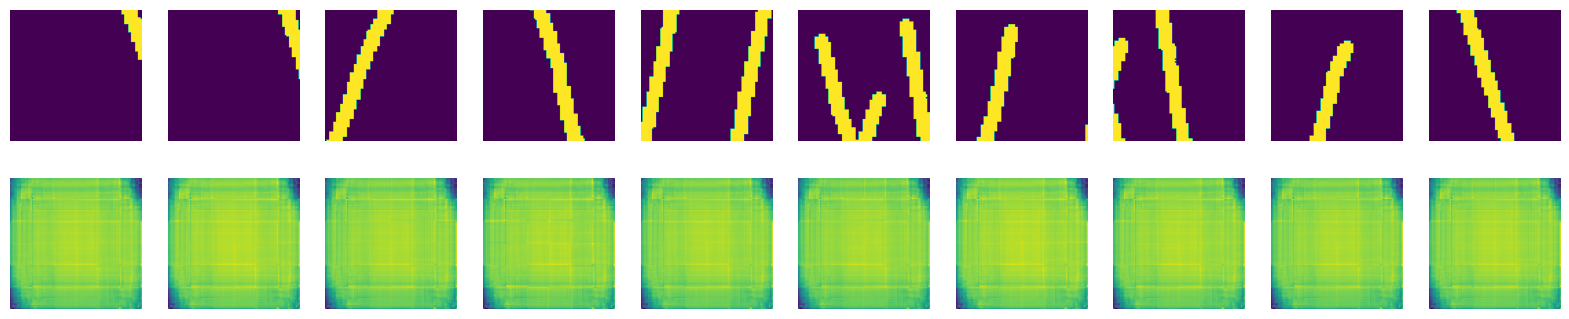

In [13]:
if INTERACTIVE_SESSION:
    display_sample_images(x_test, decoded_imgs, conf.img_shape)
    display_sample_images(y_test, decoded_imgs, conf.img_shape)

In [14]:
import cv2

def threshold_image(image, threshold_value):
    _, binary_image = cv2.threshold(image, threshold_value, 1, cv2.THRESH_BINARY)
    return binary_image

threshold_label = threshold_image(decoded_imgs,0.5)

In [15]:
decoded_imgs.shape

(66077, 96, 96, 1)

In [16]:
threshold_label.shape

(66077, 96)